## Deep Learning on AWS - Sentiment analysis on movie reviews

Lets build a model to predict the sentiment of the movie review (Positive or Negative)

@sunilmallya

@jrhunt

Dataset and use case credit to David Ping

### Twitch Video Link: https://www.twitch.tv/videos/169476156

# Dataset Overview

The training and testing dataset is the IMDB movie review database.  

It has 50,000 movie reviews that are labelled with either a negative(0) or a positive(1) sentiment. 

We will split the dataset into 25,000 reviews for training and 25,000 reviews for testing.

## Download Link


http://ai.stanford.edu/~amaas/data/sentiment/

# Setup

For th easiest Deep Learning environment I recommend using the AWS using Deep Learning AMI, please read [this post on AWS AI Blog](https://aws.amazon.com/blogs/ai/the-aws-deep-learning-ami-now-with-ubuntu/) for detailed instructions. 

# Load Modules

In [4]:
import mxnet as mx
import numpy as np

#https://keras.io/preprocessing/text/
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python2.7/dist-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Process Movie Review Data

The dataset can be downloaded from http://ai.stanford.edu/~amaas/data/sentiment/. We will process the unzipped raw reviews into traing and testing datasets for training and validation purpose.

In [1]:
# Load the data
import sys
import os

path = 'aclImdb'

files = [path + '/train/pos/' + f for f in os.listdir(path + '/train/pos/')] +  \
    [path + '/train/neg/' + f for f in os.listdir(path + '/train/neg/')] +\
    [path + '/test/pos/' + f for f in os.listdir(path + '/test/pos/')] +\
    [path + '/test/neg/' + f for f in os.listdir(path + '/test/neg/')]


In [2]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

input_text  = []

for fname in files:
    with open(fname) as f:
        input_text += [remove_tags(" ".join(f.readlines()))]

In [5]:
num_words = 10000

tok = Tokenizer(num_words)
tok.fit_on_texts(input_text[:25000])

In [6]:
# Create Training & test data;  input data (X) and Labels (Y) 

# Labels 
input_label = ([1] * 12500 + [0] * 12500) * 2

# Words will be replaced with index        
X_train = tok.texts_to_sequences(input_text[:25000])
X_test  = tok.texts_to_sequences(input_text[25000:])
y_train = input_label[:25000]
y_test  = input_label[25000:]

In [7]:
#MAX Review Length
MAX_LENGTH = 500

X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

#http://mxnet.io/api/python/io.html#mxnet.io.NDArrayIter
batch_size = 250
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
test_iter = mx.io.NDArrayIter(X_test, y_test, batch_size, shuffle=True)

# Time to build the model

In [9]:
data = mx.sym.Variable('data')
target = mx.sym.Variable('softmax_label')  # placeholder for label

emb = mx.sym.Embedding(data=data, input_dim=num_words, output_dim=32, name='embed') 

# MLP only accepts 1D vector, hence flatten
f_data = mx.sym.Flatten(data=emb, name='flatten')
fc1  = mx.sym.FullyConnected(data=f_data, num_hidden=250)
act1 = mx.sym.Activation(data=fc1, act_type="relu")  
fc2 = mx.sym.FullyConnected(data=act1, num_hidden=2) 
mlp = mx.sym.SoftmaxOutput(data=fc2, label=target, name='softmax')

# Lets visualize the network
#mx.viz.plot_network(mlp)

# Model Training

In [11]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

num_epoch = 10
ctx = [mx.gpu(i) for i in range(1)]

mlp_model = mx.mod.Module(symbol=mlp, context=ctx) 
mlp_model.fit(train_iter,              
    eval_data=test_iter,                          
    optimizer="adam",  # use adam optimizer to train
    optimizer_params={'learning_rate':0.01},        
    eval_metric='acc',  
    batch_end_callback = mx.callback.Speedometer(batch_size, 100),
    num_epoch=num_epoch)

INFO:root:Epoch[0] Train-accuracy=0.793280
INFO:root:Epoch[0] Time cost=2.362
INFO:root:Epoch[0] Validation-accuracy=0.880280
INFO:root:Epoch[1] Train-accuracy=0.950360
INFO:root:Epoch[1] Time cost=2.323
INFO:root:Epoch[1] Validation-accuracy=0.859280
INFO:root:Epoch[2] Train-accuracy=0.984000
INFO:root:Epoch[2] Time cost=2.319
INFO:root:Epoch[2] Validation-accuracy=0.857160
INFO:root:Epoch[3] Train-accuracy=0.983880
INFO:root:Epoch[3] Time cost=2.323
INFO:root:Epoch[3] Validation-accuracy=0.849560
INFO:root:Epoch[4] Train-accuracy=0.984000
INFO:root:Epoch[4] Time cost=2.322
INFO:root:Epoch[4] Validation-accuracy=0.845560
INFO:root:Epoch[5] Train-accuracy=0.988240
INFO:root:Epoch[5] Time cost=2.322
INFO:root:Epoch[5] Validation-accuracy=0.842640
INFO:root:Epoch[6] Train-accuracy=0.994600
INFO:root:Epoch[6] Time cost=2.322
INFO:root:Epoch[6] Validation-accuracy=0.854720
INFO:root:Epoch[7] Train-accuracy=0.999360
INFO:root:Epoch[7] Time cost=2.321
INFO:root:Epoch[7] Validation-accuracy=0

# Model Evaluation
We already evaluated the model during training.  Let's also try evaluating the trained model separately from the traing step

In [12]:
metric = mx.metric.Accuracy()
mlp_model.score(test_iter, metric)

[('accuracy', 0.85316)]

# Saving The Model

Now we have the model fully trained, we can save the model for reuse later
2 files will be generated
json file captures the network configuration of the neural network
params file captures the learned parameters for the network

In [13]:
# Save the model
prefix = "twitch_imdb"
mlp_model.save_checkpoint (prefix, num_epoch)

INFO:root:Saved checkpoint to "twitch_imdb-0010.params"


# Making Predictions


# Load Saved Model

In [14]:
prefix = "twitch_imdb"
pred_model = mx.mod.Module.load(prefix, num_epoch, False)

# We load the model for only forward pass, so for_training=False
# Set the data shape for 1 single batch example of size (1,500) => (batch_size, MAX_LENGTH)
pred_model.bind(for_training=False, data_shapes=[('data', (1, MAX_LENGTH))])

/home/ubuntu/mxnet/python/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [15]:
# Remember we need the input to test in the same format as we trained
def prepare_imdb_list(text, maxlen=500, vocabsize=10000):

    # the index to the vocabular we built earlier
    imdb_word_index = tok.word_index 
    sentence = []
    sentence.append(str(text))
    
    #tokenize the input sentence
    tokens = Tokenizer()
    tokens.fit_on_texts(sentence)

    # get a list of words from the encoding
    words = []
    for iter in range(len(tokens.word_index)):
        words += [key for key,value in tokens.word_index.items() if value==iter+1]

    imdb_seq = []
    for w in words:
        idx = imdb_word_index[w]
        if idx < vocabsize:
            imdb_seq.append(idx)

    new_list = []
    new_list.append(imdb_seq)
    new_list = pad_sequences(new_list, maxlen=maxlen)
    
    return new_list


def predict_sentiment(model, text_nd):
    sentence_Iter = mx.io.NDArrayIter(text_nd, batch_size=1)
    pred = pred_model.predict(sentence_Iter)

    return pred

def handle_submit(sender):
    text_nd = prepare_imdb_list(inputtext.value)
    pred = predict_sentiment(pred_model, text_nd)
    outputlabel_0.value = 'Probability for negative sentiment (0):  %0.4f ' % pred.asnumpy()[0:1,0]
    outputlabel_1.value = 'Probability for positive sentiment (1):   %0.4f ' % pred.asnumpy()[0:1,1]

# Lets have some fun with testing the model

In [17]:
from IPython.display import display 
from IPython.html import widgets
inputtext = widgets.Textarea()

display(inputtext)

inputbutton = widgets.Button(description='Predict Sentiment')

display(inputbutton)

outputlabel_0 = widgets.HTML()
outputlabel_1 = widgets.HTML()
display(outputlabel_0)
display(outputlabel_1)

inputbutton.on_click(handle_submit)

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/ipywidgets/widgets/widget.py:166: DeprecationWarning: Widget._keys_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _keys_default(self):


### More adventurous readers scroll below :)

### Lets try building an MLP model to do the same with MXNet's imperative interface Gluon

Make sure you install it by running 

pip install mxnet --pre

Gluon Tutorial: https://github.com/zackchase/mxnet-the-straight-dope

# MXNet Gluon Interface

In [ ]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

ctx = mx.cpu()

num_outputs = 2
num_hidden = 256
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Embedding(vocabsize, 32, weight_initializer=mx.init.Uniform(0.1)))
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(num_hidden, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))
    
    
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})


def evaluate_accuracy(data_iterator, net, shape_n=500):
    acc = mx.metric.Accuracy()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data = batch.data[0].as_in_context(ctx).reshape((-1,shape_n))
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]


In [ ]:
epochs = 10
moving_loss = 0.

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_iter):
        data = batch.data[0].as_in_context(ctx).reshape((-1,500))
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data.shape[0], ignore_stale_grad=True)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = nd.mean(cross_entropy).asscalar()
        else:
            moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
            
    test_accuracy = evaluate_accuracy(test_iter, net)
    train_accuracy = evaluate_accuracy(train_iter, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

[0.812929830771, 0.404830086653, 0.194560304798, 0.0949568697476, 0.0540652401239, 0.0192620222058, 0.0256203386385, 0.0162229706022, 0.0194205419608, 0.0193563111006]


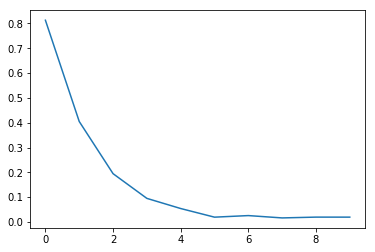

In [18]:
# Plot the loss function and see the curve

content = '''Epoch 0. Loss: 0.812929830771, Train_acc 0.78576, Test_acc 0.7498
Epoch 1. Loss: 0.404830086653, Train_acc 0.95528, Test_acc 0.86884
Epoch 2. Loss: 0.194560304798, Train_acc 0.9746, Test_acc 0.8424
Epoch 3. Loss: 0.0949568697476, Train_acc 0.98632, Test_acc 0.85032
Epoch 4. Loss: 0.0540652401239, Train_acc 0.99656, Test_acc 0.84576
Epoch 5. Loss: 0.0192620222058, Train_acc 0.99904, Test_acc 0.86436
Epoch 6. Loss: 0.0256203386385, Train_acc 0.99788, Test_acc 0.85636
Epoch 7. Loss: 0.0162229706022, Train_acc 0.99724, Test_acc 0.85216
Epoch 8. Loss: 0.0194205419608, Train_acc 0.9978, Test_acc 0.84712
Epoch 9. Loss: 0.0193563111006, Train_acc 0.99904, Test_acc 0.85124'''

loss_points = [float(c.split(" ")[3].rstrip(',')) for c in content.split('\n')]
print loss_points

import matplotlib.pyplot as plt
plt.plot(loss_points)
plt.show()